# Review Challenge

## Définition du problème 

Dans ce challenge, nous allons explorer divers méthodes afin de prédire si la review d'un utilisateur peut être utile pour les autres utilisateurs.

Ici, il s'agit d'une prédiction binaire uniquement, "utile" ou "inutile", et nous disposons de reviews de PriceMinister. 

Dans un premier temps, nous allons explorer le dataset fourni pour déterminer les éléments clés nécessaire afin d'obtenir un modèle adéquat à notre problèmatique. Nous allons notamment sélectionner et construire les différentes features dont nous aurions besoin.

Ensuite, nous allons passer à la partie de classification, avec une sélection et comparaison de plusieurs modèles et méthodes, afin d'avoir une vue d'ensemble sur les choix à effectuer.

Enfin, nous finirons sur une discussion des différents résultats et une mise en place des différents éléments pour la submission.

## Data Preparation

In [198]:
## Imports

# Data handling
import pandas as pd

# Mathematic libraries
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# NLP tools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD

# Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, RandomTreesEmbedding,
                              GradientBoostingClassifier)
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV

# Utils
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
import re


%matplotlib inline

In [89]:
## Pre-built function
def train_eval_class(classifier, train_x, train_y, val_x, val_y_true):
    # training classifier with training data
    clf = classifier.fit(train_x, train_y)

    # Prediction on validation set
    val_y_hat = clf.predict(val_x)

    # Validation set score
    return roc_auc_score(val_y_true, val_y_hat)


def score_function(y_true, y_pred):
    # Classifier score
    return roc_auc_score( y_true , y_pred )

    

# Custom tranform class for NaiveBaysan classification
class SparseMatrixToDenseArray(object):

    def transform(self, X):
        return X.toarray()

    def fit(self, X, y=None):
        return self
    
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.
    Extract column from panda DataFrame

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    
class TextStats(BaseEstimator, TransformerMixin):
    """ For text type data, retrieve number of characters, words and sentences, usually
        used in radibilty mesures.
    """

    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        """
        Return number of words, characters and sentences, but also text length.
        Return in form of list of dict.
        """
        return [
            {
                "characters" : len(text) - text.count(' '),
                "words": len(re.findall(r"[\w']+", text)),
                "sentences": text.count('.') + text.count('!') + text.count('?'),
                "length" : len(text)
            }
            for text in texts
        ]

In [3]:
## Input datas

# Original datasets
train_full = pd.read_csv('data/train.csv', delimiter=';', encoding="utf-8")
test = pd.read_csv('data/test.csv', delimiter=';')

# Split training into validation/train with ration of 25/75
train, val = train_test_split(train_full, test_size = 0.25)

# Get true label for trainand valid 
train_y = train["Target"]
val_y_true = val["Target"]


## Data Exploration

Tout d'abord, nous allons explorer notre dataset 

In [4]:
train_full[:5]

,ID,review_content,review_title,review_stars,product,Target
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,7b37bf5dcb2fafd9229897910318a7dfa11a04ca36893c...,0
3,3,tres bon rapport qualite prix tre pratique en ...,bon produit,4,77d2dbd504b933ab3aaf7cb0cd81c22f7c3549012f4f88...,1
4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,f574512e7d2dd1dd73c7f8f804bf16f14c932c5651a01b...,1


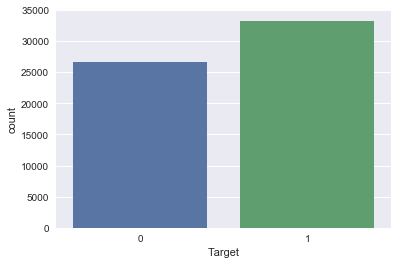

In [5]:
# Proportion of useful and not useful reviews
sns.countplot(x="Target", data=train_full)

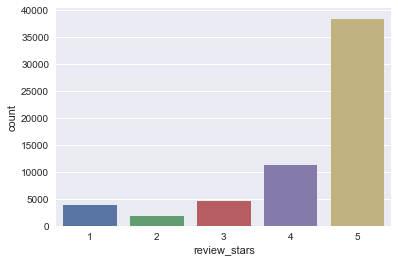

In [6]:
# review stars distribution
sns.countplot(x="review_stars", data = train_full)

In [308]:
train_full['product'].describe()

count                                                 60000
unique                                                46293
top       5568d0e86c5cc400ce85779617c698e017558dc803e75d...
freq                                                    135
Name: product, dtype: object

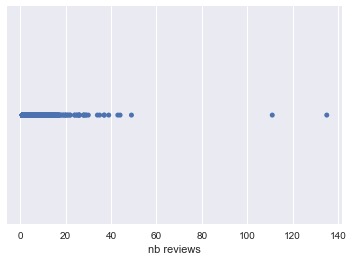

In [309]:
## Number of product distribution
# Replace product by int
prod_int = pd.factorize(train_full['product'])[0]
train_full['prod_int'] = prod_int
# Frequency distrinution
prod_freq = pd.Series(prod_int).value_counts()
ax = sns.stripplot(x=prod_freq)
ax.set(xlabel='nb reviews')
plt.show()

Les premières observations sont les suivantes :
- Les reviews utiles et inutiles semblent plus ou moins équilibré, de ce fait, un estimateur random ou totalement déterminitique atteignerait déjà les 50% de précision.
- La plupart des review ont la note maximal, ce qui en fait un indiquateur peu fiable compte tenu de la proportion de review utiles et inutiles.
- La majeure partie de produit n'ont qu'une seule review, mais certains en possède énormémant comparé aux autres. Il pourrait être intéressant de les clusturiser.

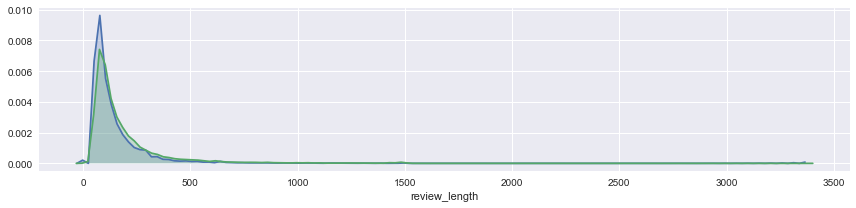

In [7]:
# Add feature review length
review_length = train_full["review_content"].apply(lambda x : len(x))
train_full["review_length"] = review_length
facet = sns.FacetGrid( train_full , hue="Target" , aspect=4 )
facet.map( sns.kdeplot , "review_length" , shade= True )

L'intuition derrière la longeur de la review, serait de dire que les review inutiles ont tendences à être courtes comparé aux utiles. Malheureusement, notre intuition semble incorrecte aux vues de la distribution ci-dessus.

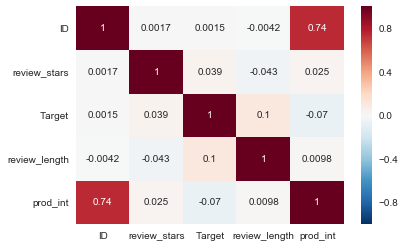

In [310]:
## Variable correlation matrix
corr = train_full.corr()
sns.heatmap(corr, annot=True)

Toutes les données, excepté le texte, ne semble pas avoir une influence notable sur l'utilité d'une review. Cependant, des testes plus poussés avec des features NLP pourraient être intéressant.

## Données texte et construction des features NLP
Comme nous l'avons observé, les divers features autres que le texte semble peu propice à une bonne classification. 
Sachant qu'une review est principalement jugé sur son contenu, nous allons construire des features à partir de ce texte en utilisant des technique de NLP. 
Nous  prenons en compte ici seulement le contenu de la review ("review_content")

### WordCount 
Wordcount est l'une des techniques les plus basique qui consiste à construire un vocabulaire à partir des différent textes et à compter les occurences des différents mots pour un seul texte.

In [9]:
# Count word occurences in text features
count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(train["review_content"])
train_counts.shape

(45000, 58727)

In [295]:
pd.DataFrame(count_vect.vocabulary_.items()[:10], columns=["word", '#occurences'])

,word,#occurences
0,rilke,46258
1,cordiament,13380
2,woode,56931
3,bouddhisme,8097
4,climatique,11329
5,huileux,26802
6,ausitot,6008
7,instalées,28473
8,accueille,2442
9,spiders,50422


Nous avons désormais nos différents textes représentés en tant que feature vector dans un vocabulaire composé de l'ensemble des mots. 

### TF-IDF
Wordcount nous a permis d'avoir le nombre d'occurance des mots au sein d'un texte. Cependant, la longueur du texte aura une grande influence sur le nombre de mots qui apparaissent ou même les répétitions. 

Un autre problème est celui du vocabulaire commun à tous les textes, aussi bien utile que inutile. En effet, il semblerait logique de mettre en avant les termes plutôt "uniques" des bonnes reviews que ceux communs à tous. 

Pour cela, nous utilisons la technique TF-IDF pour "Term Frequency and Inverse Document Frequency" qui permet non seulement de prendre en compte l'occurence de certains terme en fonction de la longeur du texte pour en retiré la fréquence de ce term dans le document, mais aussi de pénaliser les termes communs à plusieurs textes.

In [11]:
# Reduce occurences to term frequency and inverse document frequency
tfidf_tr = TfidfTransformer()
train_tfidf = tfidf_tr.fit_transform(train_counts)
train_tfidf.shape

(45000, 58727)

### Latent Sementic Analysis

LSA est une méthode de réduction de feature qui permet de relier les différents termes et documents à des "conceptes", assez similair aux variables latentes dans les techniques de recommendation basé sur la factorisation de matrice. 

LSA applique une Singular Value Decomposition (SVD) à la matrice TF-IDF. Cela à plusieurs avantages, notamment celui de réduire le nombre de dimensions à un subset qui est beaucoup plus "descriptif". Nous avons donc un matrix features plus dense. 

Certaines documentations affirment que la SVD réduirait le bruit de notre matrices et la densité apporterait une amélioration de la classification.  Un avantage personnel que nous constatons, c'est la transformation de donnée dite "dures" (féquence de mots, ...) à des données plus "abstraites (conceptes, sujets, ...) qui découlerait plus d'une analyse de texte que d'une simple lecture froide sans réflexion.

In [12]:
# SVD to 100 features (common value for LSA)
lsa_tr = TruncatedSVD(n_components=100)
train_lsa = lsa_tr.fit(train_tfidf)
train_lsa.components_

array([[  4.61766238e-04,   1.19746421e-03,   3.16004521e-05, ...,
          1.76047431e-05,   9.05940443e-04,   1.55366475e-04],
       [ -2.24869185e-04,  -5.35864935e-04,  -1.40926674e-05, ...,
         -1.47713398e-05,  -4.93414191e-04,  -1.16866029e-04]])

## Classificateurs

Désormais, nous avons des features, certes simples, mais qui tente de décrire au mieux nos reviews. Nous allons à présent entraîner un classificateur afin d'obtenir un modèle mathématique qui puisse classifier nos reviews  Nous allons essayer l'une des techniques les plus connue, la régression logistique, afin d'obtenir une première baseline sur laquelle nous pourrons nous baser afin d'apporter des amélioration.


### Logistic Regression

In [13]:
# setup input train and validation as text only
train_x = train["review_content"]
val_x = val["review_content"]

In [14]:
# Pipeline setup for simple classification
lr_clf_pip = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(max_iter=1000))])

In [15]:
# Logistic Regression with default values for training
lr_clf = lr_clf_pip.fit(train_x, train_y)

# Prediction on validation set
val_y_hat = lr_clf.predict(val_x)

# Validation set score
roc_auc_score(val_y_true, val_y_hat)

0.6440424384103578

In [16]:
# Comparison to simple results such as random or only ones results
print(roc_auc_score(val_y_true, [1]*len(val_y_true)))
from random import *
randBinList = lambda n: [randint(0,1) for b in range(1,n+1)]

print(roc_auc_score(val_y_true, randBinList(len(val_y_true))))

0.5
0.501402625427


Il semblerait que notre modèle uniquement basé sur le texte semble apporter une plus value sur une classification aléatoire des review. Avec une performance proche des 65%, il est encourageant de penser que, potentiellement, d'autres classificaters, des features NLP plus travaillées et une investigation plus approfondies sur les paramètres de classifications pourront améliorer les performances actuelles.

In [17]:
lr_clf_pip = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lsa', TruncatedSVD(n_components=1000)),
                     ('clf', LogisticRegression(max_iter=10000))])

In [18]:
train_eval_class(lr_clf_pip, train_x, train_y, val_x, val_y_true)

0.63190073727746809

Contrairement aux premières intuitions, il semble que LSA n'améliore pas la précision.
En regardant notre analyse du dataset faite précédemment, on remarque aussi que la plupart des produits n'ont qu'une seul review et que, par conséquent, il semblerait normal que les reviews aient des sujets assez différents. Cependant, après plusieurs essais, il se trouve que le training et SVD soit assez sensible à plusieurs hyper-paramètres et mériterait peut être de plus longues explorations. 

### Benchmark autres classificateurs
LogisticRegression n'est pas la seul solution en terme de classificateur. Il semble raisonnable de faire une comparaison avec les classificateurs suivants :
- Gaussian Naive Baysian
- Nearest Neighbors
- Random Forest
- Decision Tree
- Linear Singular Vector Machine (lsvm)

In [19]:
# Pipelines
pipelines = [
("gnb_clf_pip" , Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('todensearray', SparseMatrixToDenseArray()),
                     ('clf', GaussianNB())])),
("knn_clf_pip" , Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier())])),
("dt_clf_pip" ,  Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', DecisionTreeClassifier())])),
("rf_clf_pip" , Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier())])),
("lsvm_clf_pip" , Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC())]))
]

In [20]:
eval_class = []
# Training and evaluation
for pip_name, pip_obj in pipelines :
    print("computing " + pip_name + " ...")
    eval = train_eval_class(pip_obj,train_x, train_y, val_x, val_y_true)             
    eval_class.append([pip_name, eval])

computing gnb_clf_pip ...
computing knn_clf_pip ...
computing dt_clf_pip ...
computing rf_clf_pip ...
computing lsvm_clf_pip ...


In [24]:
# Classifiers comparison on evaluation set
eval_class_np = np.array(eval_class)
pd.DataFrame({"classifier":eval_class_np[:,0], "eval_score":eval_class_np[:,1]})

,classifier,eval_score
0,gnb_clf_pip,0.55324402086
1,knn_clf_pip,0.53784840856
2,dt_clf_pip,0.590718395972
3,rf_clf_pip,0.625496313613
4,lsvm_clf_pip,0.635382125517


L'ensemble des résultats semblent proches et en tout cas en dessous de la régression logistique . Cependant, ces différents classifiers peuvent être optimisé en ce qui concerne les hyper-paramètres. Cependant, on peut déjà éliminer Gaussian Naive Bayes et K Nearest Neighbors ( tdlr : Dans le cas de KNN, nous avons testé avec différentes valeurs de K, sans succès au niveau de la précision).

Une investigation intéressante, serait l'utilisation de LSA pour ces autres classificateurs.

In [26]:
## KNN with LSA
knn_clf_pip =  Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=10))])
train_eval_class(knn_clf_pip,train_x, train_y, val_x, val_y_true) 

0.53404064017263075

In [27]:
pipelines_lsa = [
    ("dt_clf_pip" ,  Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lsa', TruncatedSVD(n_components=100)),
                     ('clf', DecisionTreeClassifier())])),
    ("rf_clf_pip" , Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lsa', TruncatedSVD(n_components=100)),
                     ('clf', RandomForestClassifier())])),
    ("lsvm_clf_pip" , Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lsa', TruncatedSVD(n_components=100)),
                     ('clf', LinearSVC())]))
]


In [29]:
eval_lsa_class = []
# Training and evaluation
for pip_name, pip_obj in pipelines_lsa :
    print("computing " + pip_name + " ...")
    eval = train_eval_class(pip_obj,train_x, train_y, val_x, val_y_true)             
    eval_lsa_class.append([pip_name, eval])

computing dt_clf_pip ...
computing rf_clf_pip ...
computing lsvm_clf_pip ...


In [296]:
## Comparison classifiers with LSA on evaluation set
eval_lsa_class_np = np.array(eval_lsa_class)
pd.DataFrame({"classifier":eval_lsa_class_np[:,0], "eval_score":eval_lsa_class_np[:,1]})

,classifier,eval_score
0,dt_clf_pip,0.582103938141
1,rf_clf_pip,0.59020589822
2,lsvm_clf_pip,0.602833123539


Nous observé jusqu'à présent les limitations du contenu de la review avec de classifiers non-optimisé au niveau des hyper-paramètres. Cependant, nous n'avons pas pris en compte d'autres facteurs qui puissent paraître important tel que :
- La lisibilité et la facilité de lecture. Une review trop complexe ou illisible ne sera que peu utile.
- Le titre. Il semble important d'attirer l'attention sur une review spécifique avec un titre accrocheur
    
Dans les prochaines sections, nous allon tenter d'utilisé ces features potentiels et les combiner à nos features actuelles.

### Title analysis

In [69]:
title_content_pip_clf = Pipeline([
    ('union', FeatureUnion([
        ('title', Pipeline([
            ('select', ItemSelector(key="review_title")),
            ('transform', TfidfVectorizer())
        ])),
        ('content', Pipeline([
            ('select', ItemSelector(key="review_content")),
            ('transform', TfidfVectorizer())
        ]))
    ])),
    ('clf', LogisticRegression(max_iter=3000))
])

In [73]:
train_eval_class(title_content_pip_clf, train, train_y, val, val_y_true)

0.65313073188275494

On remarque une certaines améliorations en ajoutant cette feature. 

### Text Statistics

Concernant la facilité de lecture ou la lisibilité , ils découlent des même variables : le nombre de mot, de phrases et de caractère. Nous pouvont donc ajouter ces composant au sein de notre pipeline.

In [287]:
title_content_pip_clf = Pipeline([
    ('union', FeatureUnion([
        ('title', Pipeline([
            ('select', ItemSelector(key="review_title")),
            ('transform', TfidfVectorizer())
        ])),
        ('content', Pipeline([
            ('select', ItemSelector(key="review_content")),
            ('transform', TfidfVectorizer())
        ])),
         ('text_stats', Pipeline([
                ('select', ItemSelector(key='review_content')),
                ('stats', TextStats()),  
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ]))
    ])),
    ('clf', LogisticRegression(max_iter=3000))
])

In [288]:
train_eval_class(title_content_pip_clf, train, train_y, val, val_y_true)

0.65366840496313605

L'ajout de features supplémentaire, comme prédit par notre analyse de la correlation, n'apporte que très peu d'amélioration. 

### Méthodes non-linéaire
Notre teste final en ce qui concerne les classificateurs sera l'utilisation d'un classificateur non-linéaire: SVM. 

In [121]:
# Without LSA, kernel : poly
title_content_pip_clf = Pipeline([
    ('title', Pipeline([
            ('select', ItemSelector(key="review_title")),
            ('transform', TfidfVectorizer())
    ])),
    ('clf', SVC(C=5, ))
])
train_eval_class(title_content_pip_clf, train, train_y, val, val_y_true)

0.5

In [125]:
# With LSA; kernel rtbf
title_content_pip_clf = Pipeline([
    ('title', Pipeline([
            ('select', ItemSelector(key="review_title")),
            ('transform', TfidfVectorizer()),
            ('svd', TruncatedSVD(n_components=100))
    ])),
    ('clf', SVC(C=15))
])
train_eval_class(title_content_pip_clf, train, train_y, val, val_y_true)

0.5317155187915843

Les résultats avec des kernel non-linéaire pour SVM semblent peu convaincant (après plusieurs essais).

### Cross-Validation et optimisation des hyper-paramètres

Il semblerait que nous ayons utilisé et déduit un bon nombre de features possibles et une méthode de classification correcte. 
Désormais, il semblerait judicieux d'optimizer LogisticRegession classifier et d'ajouter des méthodes de cross-validation.

In [ ]:
# Classifier pipeline
clf_pip = Pipeline([
    ('union', FeatureUnion([
        ('title', Pipeline([
            ('select', ItemSelector(key="review_title")),
            ('tfidf', TfidfVectorizer())
        ])),
        ('content', Pipeline([
            ('select', ItemSelector(key="review_content")),
            ('tfidf', TfidfVectorizer())
        ])),
         ('text_stats', Pipeline([
                ('select', ItemSelector(key='review_content')),
                ('stats', TextStats()),  
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
    ])),
    ('clf', LogisticRegression())
])


In [221]:
# Logistic Regression parmeters
parameters = {
    'union__content__tfidf__use_idf': (True, False),
    'union__content__tfidf__smooth_idf':(True, False),
    'union__content__tfidf__sublinear_tf':(True, False),
    'union__content__tfidf__norm': ('l1', 'l2', None),
    'clf__penalty': ('l1','l2')
}

In [224]:
# Grid Search with 5-fold cross-validation ()
grid_search = GridSearchCV(clf_pip, parameters, scoring='roc_auc', cv=5, n_jobs=-1)

In [225]:
grid_search.fit(train, train_y)

[LibLinear]

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('title', Pipeline(steps=[('select', ItemSelector(key='review_title')), ('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__penalty': ('l1', 'l2'), 'union__content__tfidf__smooth_idf': (True, False), 'union__content__tfidf__use_idf': (True, False), 'union__content__tfidf__norm': ('l1', 'l2', None), 'union__content__tfidf__sublinear_tf': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [229]:
# best parameters results and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'clf__penalty': 'l2', 'union__content__tfidf__use_idf': True, 'union__content__tfidf__smooth_idf': True, 'union__content__tfidf__sublinear_tf': True, 'union__content__tfidf__norm': 'l2'}
0.712048723785


In [230]:
# Display grid search results
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__penalty,param_union__content__tfidf__norm,param_union__content__tfidf__smooth_idf,param_union__content__tfidf__sublinear_tf,param_union__content__tfidf__use_idf,params,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,85.227974,1.483329,0.684880,0.740248,l1,l1,True,True,True,"{u'clf__penalty': u'l1', u'union__content__tfi...",...,0.692322,0.738040,0.689004,0.739512,0.686958,0.739901,6.296197,0.034365,0.006034,0.001505
1,92.631523,1.565365,0.682036,0.735997,l1,l1,True,True,False,"{u'clf__penalty': u'l1', u'union__content__tfi...",...,0.688380,0.733947,0.687249,0.735341,0.683635,0.735345,10.800199,0.114739,0.005687,0.001542
2,89.625373,1.483654,0.684700,0.740137,l1,l1,True,False,True,"{u'clf__penalty': u'l1', u'union__content__tfi...",...,0.692127,0.738002,0.689090,0.739291,0.686518,0.739841,6.760962,0.047188,0.006008,0.001486
3,91.754451,1.482417,0.681624,0.735649,l1,l1,True,False,False,"{u'clf__penalty': u'l1', u'union__content__tfi...",...,0.687967,0.733625,0.687015,0.734912,0.683079,0.735058,10.234684,0.041004,0.005683,0.001535
4,85.488874,1.522564,0.684818,0.740163,l1,l1,False,True,True,"{u'clf__penalty': u'l1', u'union__content__tfi...",...,0.692273,0.737951,0.688922,0.739445,0.686919,0.739804,9.765571,0.081701,0.006036,0.001506
5,91.851646,1.553726,0.682028,0.735996,l1,l1,False,True,False,"{u'clf__penalty': u'l1', u'union__content__tfi...",...,0.688379,0.733946,0.687253,0.735341,0.683634,0.735345,10.544492,0.097727,0.005694,0.001542
6,87.040554,1.570476,0.684657,0.740057,l1,l1,False,False,True,"{u'clf__penalty': u'l1', u'union__content__tfi...",...,0.692074,0.737916,0.689017,0.739225,0.686497,0.739757,9.689095,0.053234,0.005999,0.001486
7,95.705267,1.504373,0.681628,0.735649,l1,l1,False,False,False,"{u'clf__penalty': u'l1', u'union__content__tfi...",...,0.687965,0.733625,0.687015,0.734912,0.683081,0.735058,8.128833,0.039917,0.005679,0.001535
8,162.596211,1.563034,0.701026,0.791184,l1,l2,True,True,True,"{u'clf__penalty': u'l1', u'union__content__tfi...",...,0.705790,0.790052,0.710384,0.788982,0.702574,0.791762,13.599501,0.060125,0.007254,0.001497
9,168.201494,1.562196,0.699318,0.772625,l1,l2,True,True,False,"{u'clf__penalty': u'l1', u'union__content__tfi...",...,0.703634,0.771500,0.707879,0.770177,0.701354,0.773197,18.432759,0.069059,0.006638,0.001676


Nous avons à présent un modèle avec plusieurs paramètres bien définis permettant d'obtenir une bonne accuracy. 
Nous discuterons dans la conclusions des lessons à garder de cette recherche et des améliorations à lui apporter. 

##  Conclusion

Malgré un problème qui peut sembler simple, il est vrai que la difficulté est au rendez-vous pour augmenter les performances actuelles. 

Premièrement, après une première analyse des données, notre modèle mathématique doit arriver à intégrer une notion générale de l'utilité. Après une exploration des données, les reviews intutiles peuvent s'apparenter à des experiences personnelles ou des histoire qui n'ont pas forcément un rapport direct avec le produit. Alors que les review utiles sont plus informatives sur le produit en lui-même.

Deuxièmement, la plupart des algorithmes de classification utilisés ont commun point commun d'être linéaire, assumant donc que nos données sont linéairement séparable. Cependant, plusieurs publications scientifiques et quelques testes effectué ici ont démontré que des classificateurs non-linéaires n'étaient pas forcément plus performant en terme de précision.

Au final, nous avons obtenues des performances correctes, en tout cas meilleures que des estimateurs aléatoires. Nous avons réussi à construire un modèle mathématiques plus ou moins performant. Voici les différents enseignements et améliorations possibles pour de futurs expériences :

- L'ensemble des données sont à analyser avec minutie et peuvent apporter de légères améliorations, mais surtout une bonne compréhension sur leurs diverses propriétés. Cependant, trop de features inutiles  pourrait ajouter du bruit (noise) et réduire notre précision.

- L'analyse des possible pre-process en NLP a été très instructive. En effet, LSA est souvent plus performant dans le cas de classification de textes en diverses catégories, mais c'est montré peu utile pour notre problème.

- Nous avons fait une analyse des différents classificateurs, mais cela aurait pu être plus rigoureux avec une cross-validation et une utilisation de grid search pour tester l'ensemble des paramètres. Mais les premiers essais nous ont permis d'avoir une premières approche sur le problème.


## Futurs modèles à tester

- word2vec : un neural network à deux layer permettant de capturer des features sémantiques plus abstraites et pouvant être utilisé à la place ou en combinaison de TFIDF, comme présenté sur [DS-Lore](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/). word2vec a démontré de bonne modélisation de textes et de bonne performances en ce qui concerne la précision.
- CNN for NLP : Des [exemples](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/) d'implémentations de CNN pour la classification de textes montre de bonne performances. 

## Classification avec le test dataset

In [298]:
# Rename Dataset
X_train, y_train = train_full[
    ['ID', 
     'review_title', 
     'review_content', 
     'review_stars', 
     'product']
], train_full['Target']
X_test = test

In [269]:

# Classification pipeline
clf = Pipeline([
    ('union', FeatureUnion([
        ('title', Pipeline([
            ('select', ItemSelector(key="review_title")),
            ('tfidf', TfidfVectorizer())
        ])),
        ('content', Pipeline([
            ('select', ItemSelector(key="review_content")),
            (
                'tfidf', 
                TfidfVectorizer(
                    smooth_idf=True, 
                    sublinear_tf=True, 
                    norm='l2'
                )
            )
        ])),
         ('context_stats', Pipeline([
                ('select', ItemSelector(key='review_content')),
                ('stats', TextStats()),  
                ('vect', DictVectorizer()), 
            ])),
    ])),
    ('clf', LogisticRegression(penalty='l2'))
])

# train model 
clf.fit(X_train,y_train)

# test prediction
y_test = clf.predict(X_test)

In [289]:
# Produce submission file
submission = pd.DataFrame({
    'ID' : X_test['ID'],
    'Target' : y_test
})
submission.to_csv(
    path_or_buf='christopher_salotti_submission.csv', 
    index=False, 
    sep=';'
)

In [311]:
# Export Notebook in HTML
import os 

os.system('jupyter nbconvert --to html linkvalue_challenge.ipynb')

0